# Fermi-Hubbard Model

In [250]:
using Pkg; Pkg.activate()
using KadanoffBaym
using LinearAlgebra, BlockArrays
using UnPack
using JLD

  Activating environment at `~/.julia/environments/v1.6/Project.toml`


In [251]:
using PyPlot
PyPlot.plt.style.use("./paper.mplstyle")

## Model

### Hamiltonian

$$
\begin{align}\begin{split}
    \hat{H} &= - J \sum_{\langle{i,\,j}\rangle}\sum_\sigma \hat{c}^{\dagger}_{i,\sigma} \hat{c}^{\phantom{\dagger}}_{i+1,\sigma} + U\sum_{i=1}^L  \hat{c}^{\dagger}_{i,\uparrow} \hat{c}^{\phantom{\dagger}}_{i,\uparrow}   \hat{c}^{\dagger}_{i,\downarrow} \hat{c}^{\phantom{\dagger}}_{i,\downarrow}, 
\end{split}\end{align}
$$

### Green functions

$$
    G^>_{ij}(t, t') = -i \left\langle \hat{c}^{\phantom{\dagger}}_{i,\uparrow}(t) \hat{c}^{{\dagger}}_{i,\uparrow}(t') \right\rangle\\
    F^>_{ij}(t, t') = -i \left\langle \hat{c}^{\phantom{\dagger}}_{i,\downarrow}(t) \hat{c}^{{\dagger}}_{i,\downarrow}(t') \right\rangle\\
$$

### Self-energies

Second-order Born approximation:
$$
    \Sigma_{ij, \uparrow}  (t, t') = U^2 G_{ij, \uparrow}(t, t') G_{ij, \downarrow}(t, t') G_{ji, \downarrow}(t', t),\\
    \Sigma_{ij, \downarrow}(t, t') = U^2 G_{ij, \downarrow}(t, t') G_{ij, \uparrow}(t, t') G_{ji, \uparrow}(t', t)
$$


$T$-matrix approximation:
$$
    \Sigma_{ij, \uparrow}  (t, t') = i U^2 T_{ij}(t, t') G_{ji, \downarrow}(t', t),\\
    \Sigma_{ij, \downarrow}(t, t') = i U^2 T_{ij}(t, t') G_{ji, \uparrow}(t', t)
$$

$$
   T_{ij}(t, t') =  \Phi_{ij}(t, t') - U \int_{\mathcal{C}}\mathrm{d}s\; \boldsymbol{\Phi}(t, s) \boldsymbol{T}(s, t')
$$

$$
    \Phi_{ij}(t, t') = -i G_{ij, \uparrow}(t, t') G_{ij, \downarrow}(t, t')
$$

$$
   T^\lessgtr_{ij}(t, t') =  \Phi^\lessgtr_{ij}(t, t') - U \int_{0}^{t}\mathrm{d}s\; [\boldsymbol{\Phi}^>(t, s) - \boldsymbol{\Phi}^<(t, s)] \boldsymbol{T}^\lessgtr(s, t') - U \int_{0}^{t'}\mathrm{d}s\; \boldsymbol{\Phi}^\lessgtr(t, s)[\boldsymbol{T}^<(s, t') - \boldsymbol{T}^>(s, t')]
$$

## Solving

In [252]:
num_sites = 2;

In [253]:
# 8-site 3D cubic lattice
h = BlockArray{ComplexF64}(undef_blocks, [4, 4], [4, 4])
diag_block = [0 -1 0 -1; -1 0 -1 0; 0 -1 0 -1; -1 0 -1 0]
setblock!(h, diag_block, 1, 1)
setblock!(h, diag_block, 2, 2)
setblock!(h, Diagonal(-1 .* ones(4)), 1, 2)
setblock!(h, Diagonal(-1 .* ones(4)), 2, 1)

full_h = BlockArray{ComplexF64}(undef_blocks, [8, 8], [8, 8])
setblock!(full_h, h |> Array, 1, 1)
setblock!(full_h, h |> Array, 2, 2)
setblock!(full_h, zeros(ComplexF64, 8, 8), 1, 2)
setblock!(full_h, zeros(ComplexF64, 8, 8), 2, 1)

full_h = full_h |> Array;

In [254]:
Base.@kwdef struct FermiHubbardModel
    U::Float64
#     H = ComplexF64[0 -1 0 0; -1 0 0 0; 0 0 0 -1; 0 0 -1 0] # two-site 1D chain
    H = ComplexF64[0 -1 ; -1 0 ] # two-site 1D chain
    
    # 8-site 3D cubic lattice
#     H = full_h
end

FermiHubbardModel

In [255]:
struct FermiHubbardData{T, S}
    GL::T
    GG::T
    
    TL::S
    TG::S    
    
    ΣNCA_c_L::T
    ΣNCA_c_G::T
    
    dot_GL_GL::S
    dot_GG_GG::S
    
    # Initialize problem
    function FermiHubbardData(GL::T, GG::T, TL::S, TG::S) where {T, S}
        new{T, S}(GL, GG, zero(TL), zero(TG), zero(GL), zero(GG), zero(TL), zero(TG))
    end
end

In [256]:
# struct FermiHubbardData{T}
#     GL::T
#     GG::T
#     FL::T
#     FG::T

#     ΣNCA_c_L::T
#     ΣNCA_c_G::T
#     ΣNCA_f_L::T
#     ΣNCA_f_G::T

#     # Initialize problem
#     function FermiHubbardData(GL::T, GG::T, FL::T, FG::T) where {T}
#         new{T}(GL, GG, FL, FG, zero(GL), zero(GG), zero(FL), zero(FG))
#     end
# end

In [257]:
function fv!(model, data, out, times, t, t′)
    @unpack GL, GG, TL, TG, ΣNCA_c_L, ΣNCA_c_G, dot_GL_GL, dot_GG_GG = data
    @unpack H, U = model 
    
    if (n = size(GL, 3)) > size(dot_GL_GL, 3)
        resize!(dot_GL_GL, n)
        resize!(dot_GG_GG, n)
    end    
    
    # real-time collision integral
    ∫dt(i, j, A, B) =
        sign(j - i) * integrate(times[min(i, j):max(i, j)],[A[t, s] * B[s, t′] for s = min(i, j):max(i, j)])
    
    # real-time collision integral
    ∫dt_(i, j, A, B) =
        sign(j - i) * integrate(times[min(i, j):max(i, j)],[A(t, s) * B[s, t′] for s = min(i, j):max(i, j)])    
    
    ΣHF_c(t, t′) =  1.0im * U * Diagonal([GL[k, k, t, t] for k in 1:num_sites])
    
    rhs_L(t, t′) = -1.0im * ((H[1:num_sites, 1:num_sites] + ΣHF_c(t, t′)) * GL[t, t′] + 
                            ∫dt(1, t, ΣNCA_c_G, GL) + ∫dt(t, t′, ΣNCA_c_L, GL) - ∫dt(1, t′, ΣNCA_c_L, GG)
                            )
    
    rhs_G(t, t′) = -1.0im * ((H[1:num_sites, 1:num_sites] + ΣHF_c(t, t′)) * GG[t, t′] + 
                            ∫dt(t′, t, ΣNCA_c_G, GG) - ∫dt(1, t, ΣNCA_c_L, GG) + ∫dt(1, t′, ΣNCA_c_G, GL)
                            )
    
    out[1] = rhs_L(t, t′)
    out[2] = rhs_G(t, t′)

    dot_GL_GL_func(t, t′) = 2 .* rhs_L(t, t′) .* GL[t, t′]
    dot_GG_GG_func(t, t′) = 2 .* rhs_G(t, t′) .* GG[t, t′]
  
    
#     out[3] = (dot_GL_GL_func(t, t′)
#               + 1.0im .* U .* (GG[t, t] .* GG[t, t] - GL[t, t] .* GL[t, t]) * TL[t, t′] 
#               + 1.0im .* U .* (∫dt_(1, t, dot_GG_GG_func, TL) + ∫dt_(t, t′, dot_GL_GL_func, TL) - ∫dt_(1, t′, dot_GL_GL_func, TG))
#              )
    
#     out[4] = (dot_GG_GG_func(t, t′)
#               + 1.0im .* U .* (GG[t, t] .* GG[t, t] - GL[t, t] .* GL[t, t]) * TG[t, t′]
#               + 1.0im .* U .* (∫dt_(t′, t, dot_GG_GG_func, TG) - ∫dt_(1, t, dot_GL_GL_func, TG) + ∫dt_(1, t′, dot_GG_GG_func, TL))
#              )
end

function fd!(model, data, out, times, t, t′)
    fv!(model, data, out, times, t, t)
    out[1:2] .-= adjoint.(out[1:2])
    out[3:4] .+= adjoint.(out[3:4])
end

fd! (generic function with 1 method)

In [258]:
# myout = [data.GL[1,1], data.GG[1,1], data.TL[1,1], data.TG[1,1]]

function self_energies!(model, data, times, t, t′)
    @unpack GL, GG, TL, TG, ΣNCA_c_L, ΣNCA_c_G, dot_GL_GL, dot_GG_GG = data
    @unpack U = model

    if (n = size(GL, 3)) > size(ΣNCA_c_L, 3)
        resize!(ΣNCA_c_L, n)
        resize!(ΣNCA_c_G, n)
    end
    
#     fv!(model, data, myout, times, t, t′)
#     if t == t′
#         myout[1:2] .-= adjoint.(out[1:2])
#         myout[3:4] .+= adjoint.(out[3:4])
#     end
    
#     dot_GL_GL[t, t′] = (2myout[1] .* GL[t, t′])
#     dot_GG_GG[t, t′] = (2myout[2] .* GG[t, t′])
    
    TL[t, t′] = GL[t, t′] .* GL[t, t′]
    TG[t, t′] = GG[t, t′] .* GG[t, t′]
    
    ΣNCA_c_L[t, t′] = U^2 .* TL[t, t′] .* transpose(GG[t′, t])
    ΣNCA_c_G[t, t′] = U^2 .* TG[t, t′] .* transpose(GL[t′, t])
end

self_energies! (generic function with 1 method)

In [259]:
# quantum numbers
dim = num_sites

# Define your Green functions at (t0, t0) – time arguments at the end
GL = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
GG = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)

TL = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), Symmetrical)
TG = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), Symmetrical)

# Initial condition
N_c = zeros(num_sites)
N_c[1] = 0.5
# N_c[1:4] = [0.7, 0.0, 0.7, 0.0]
# N_f[1:4] = [0.0, 0.25, 0.0, 0.25]

# N_c[5:8] = [0.0, 0.4, 0.0, 0.4]
# N_f[5:8] = [0.65, 0.0, 0.65, 0.0]

GL[1, 1] = 1.0im * diagm(N_c)
GG[1, 1] = -1.0im * (I - diagm(N_c))

data = FermiHubbardData(GL, GG, TL, TG)
model = FermiHubbardModel(U = 0.25)
model = FermiHubbardModel(U = 5.)

data.TL[1, 1] = GL[1, 1] .* GL[1, 1]
data.TG[1, 1] = GG[1, 1] .* GG[1, 1]

tmax = 1;

In [260]:
function integrate(x::AbstractVector, y::AbstractVector)
    if isone(length(x))
        return zero(first(y))
    end

    @inbounds retval = (x[2] - x[1]) * (y[1] + y[2])
    @inbounds @fastmath @simd for i = 2:(length(y)-1)
        retval += (x[i+1] - x[i]) * (y[i] + y[i+1])
    end
    return 1 // 2 * retval
end;

In [283]:
atol = 1e-8
rtol = 1e-7;

atol = 1e-6
rtol = 1e-4;

In [272]:
@time sol = kbsolve!(
    (x...) -> fv!(model, data, x...),
    (x...) -> begin
        println(" t: $(x[2][x[3]])")
        fd!(model, data, x...)
    end,
    [data.GL, data.GG, data.TL, data.TG],
    (0.0, tmax);
    callback = (x...) -> self_energies!(model, data, x...),
    atol = atol,
    rtol = rtol,
    dtini=1e-8
);

 t: 0.0
 t: 1.0e-8
 t: 1.0e-8
 t: 6.0e-8
 t: 6.0e-8
 t: 3.1e-7
 t: 3.1e-7
 t: 1.5599999999999999e-6
 t: 1.5599999999999999e-6
 t: 7.81e-6
 t: 7.81e-6
 t: 3.9059999999999995e-5
 t: 3.9059999999999995e-5
 t: 0.00019530999999999994
 t: 0.00019530999999999994
 t: 0.0003359349999999999
 t: 0.0003359349999999999
 t: 0.0004624974999999998
 t: 0.0004624974999999998
 t: 0.0010953099999999995
 t: 0.0010953099999999995
 t: 0.004259372499999998
 t: 0.004259372499999998
 t: 0.007107028749999997
 t: 0.007107028749999997
 t: 0.014056377477882222
 t: 0.014056377477882222
 t: 0.020310791332976225
 t: 0.020310791332976225
 t: 0.029014517120652263
 t: 0.029014517120652263
 t: 0.042394558242232136
 t: 0.042394558242232136
 t: 0.05991759502142014
 t: 0.05991759502142014
 t: 0.08844444990482145
 t: 0.08844444990482145
 t: 0.11411861929988262
 t: 0.10902803366514795
 t: 0.10652665091706308
 t: 0.10652665091706308
 t: 0.12280063182808054
 t: 0.12113935725814765
 t: 0.12113935725814765
 t: 0.13498835100971782


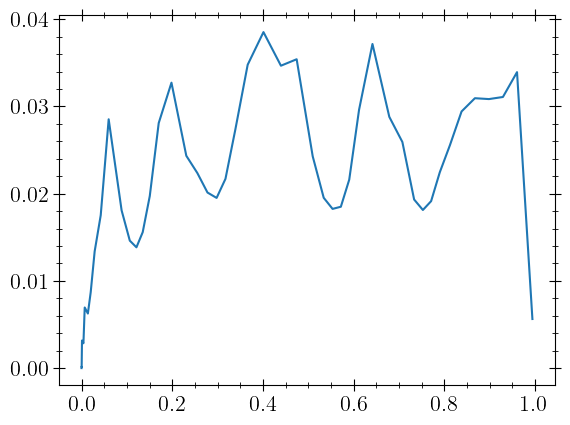

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5660f5d910>

In [273]:
plot(sol.t[1:end-1], sol.t |> diff)

In [274]:
# save("FH_1D_sol_U_"*string(model.U)*"_atol_1e-8_rtol_1e-6.jld", "solution", sol)
# save("FH_3D_T_matrix_sol_U_"*string(model.U)*"_tmax_"*string(tmax)*"_atol_"*string(atol)*"_rtol_"*string(rtol)*".jld", "solution", sol)

## Example plots

### Load data

In [304]:
# loaded_sol = load("FH_1D_sol_U_0.5_atol_1e-8_rtol_1e-6.jld")
loaded_sol = Dict()
loaded_sol["solution"] = sol; #
loaded_sol_2 = load("FH_3D_T_matrix_sol_U_"*string(model.U)*"_tmax_"*string(tmax)*"_atol_"*string(atol)*"_rtol_"*string(rtol)*".jld")

In [307]:
num_points = (loaded_sol["solution"].t |> size)[1]
num_points_2 = (loaded_sol_2["solution"].t |> size)[1]

171

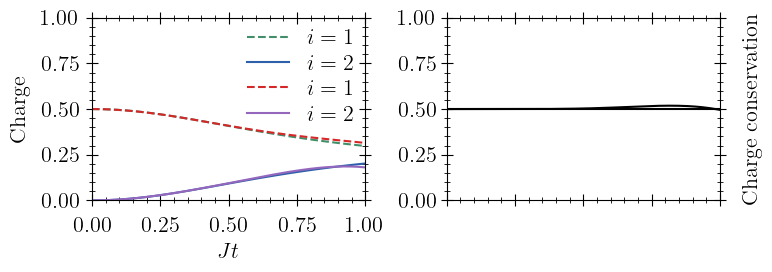

In [313]:
xpad = 8
ypad = 5

figure(figsize = (8, 3))

ax = subplot(121)
idx_1 = 1
idx_2 = 2

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_1, idx_1, k, k] .+ loaded_sol["solution"].u[3][idx_1, idx_1, k, k]) for k = 1:num_points], 
    label = "\$ i=1\$", lw=1.5, ls = "--", c = "#438E6A")

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_2, idx_2, k, k] .+ loaded_sol["solution"].u[3][idx_2, idx_2, k, k]) for k = 1:num_points], 
    label = "\$ i=2\$", lw=1.5, ls = "-", c = "#2D5FAA")

plot(loaded_sol_2["solution"].t, [imag(loaded_sol_2["solution"].u[1][idx_1, idx_1, k, k] .+ loaded_sol_2["solution"].u[3][idx_1, idx_1, k, k]) for k = 1:num_points_2], 
    label = "\$ i=1\$", lw=1.5, ls = "--", c = "C3")

plot(loaded_sol_2["solution"].t, [imag(loaded_sol_2["solution"].u[1][idx_2, idx_2, k, k] .+ loaded_sol_2["solution"].u[3][idx_2, idx_2, k, k]) for k = 1:num_points_2], 
    label = "\$ i=2\$", lw=1.5, ls = "-", c = "C4")


xlim(0, tmax)
ax.set_yticks([0, 1/4., 1/2., 3/4., 1])
ylim(-0, 1)
xlabel("\$J t\$")
# ylabel("\$\\mathrm{Im}\\; G^<_{11, \\sigma}(t, t)\$")
ylabel("Charge", labelpad = 8)
ax.xaxis.set_tick_params(pad = xpad)
ax.yaxis.set_tick_params(pad = ypad)
# ax.set_axisbelow(false)
# ticklabel_format(axis = "y", style = "sci", scilimits = (-0, 0))
ax.legend(loc = "best", handlelength = 1.9, frameon = false, borderpad = 0, labelspacing = 0.25)

ax = subplot(122)
plot(loaded_sol["solution"].t, [(sum(loaded_sol["solution"].u[1][i, i, k, k] for i = 1:num_sites) |> imag) .+ (sum(loaded_sol["solution"].u[3][i, i, k, k] for i = 1:num_sites) |> imag) for k = 1:num_points] 
    .- 0*sum(N_c) , 
    label = "\$ c \$", ls = "-", c = "k")
plot(loaded_sol_2["solution"].t, [(sum(loaded_sol_2["solution"].u[1][i, i, k, k] for i = 1:num_sites) |> imag) .+ (sum(loaded_sol_2["solution"].u[3][i, i, k, k] for i = 1:num_sites) |> imag) for k = 1:num_points_2] 
    .- 0*sum(N_c) , 
    label = "\$ c \$", ls = "-", c = "k")
xlim(0, tmax)
# ax.set_xticks([0, 8, 16, 24, 32])
ax.set_xticklabels([])
# yticks([k for k in 0:0.5:1] .* 5e-15)
ylim(0., 1)
ylabel("Charge conservation", labelpad = 16)
ax.yaxis.set_label_position("right")

tight_layout()
# savefig("fermi_hubbard_T.pdf")

In [287]:
function meshgrid(xin,yin)
  nx=length(xin)
  ny=length(yin)
  xout=zeros(ny,nx)
  yout=zeros(ny,nx)
  for jx=1:nx
      for ix=1:ny
          xout[ix,jx]=xin[jx]
          yout[ix,jx]=yin[ix]
      end
  end
  return (x=xout, y=yout)
end

Y, X = meshgrid(loaded_sol["solution"].t, loaded_sol["solution"].t);

In [288]:
cmap = "gist_heat";

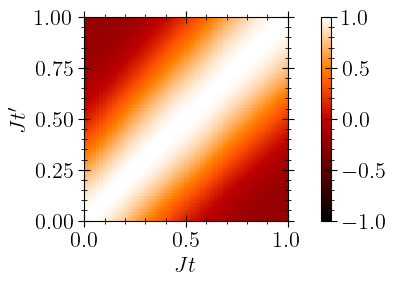

In [289]:
figure(figsize=(7, 3))
t_scale = 1
vmin = -1.0
vmax = 1.0

ax = subplot(111)
heatmap = ax.pcolormesh(X, Y, imag(loaded_sol["solution"].u[1][1, 1, :, :]) .- imag(loaded_sol["solution"].u[2][1, 1, :, :]), cmap=cmap, rasterized=true, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
cbar = colorbar(mappable=heatmap)
cbar.formatter.set_powerlimits((0, 0))
ax.set_xlabel("\$J t\$")
ax.set_ylabel("\$J t'\$")
# ax.set_xlim(0, t_scale * tmax)
# ax.set_ylim(0, t_scale * tmax)
# ax.set_xlim(0, t_scale * 8)
# ax.set_ylim(0, t_scale * 8)
# ax.set_xticks(t_scale .* [0, tmax/2, tmax])
# ax.set_yticks(t_scale .* [0, tmax/2, tmax])

# ax.set_xticks(t_scale .* [0, 2, 4, 6, 8])
# ax.set_yticks(t_scale .* [0, 2, 4, 6, 8])

tight_layout(pad=0.75, w_pad=0.5, h_pad=0)

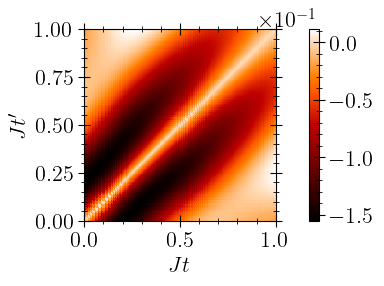

In [295]:
figure(figsize=(7, 3))
t_scale = 1
vmin = -1.0
vmax = 1.0

ax = subplot(111)
heatmap = ax.pcolormesh(X, Y, imag(loaded_sol["solution"].u[4][1, 1, :, :]), cmap=cmap, rasterized=true)#, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
cbar = colorbar(mappable=heatmap)
cbar.formatter.set_powerlimits((0, 0))
ax.set_xlabel("\$J t\$")
ax.set_ylabel("\$J t'\$")
# ax.set_xlim(0, t_scale * tmax)
# ax.set_ylim(0, t_scale * tmax)
# ax.set_xlim(0, t_scale * 8)
# ax.set_ylim(0, t_scale * 8)
# ax.set_xticks(t_scale .* [0, tmax/2, tmax])
# ax.set_yticks(t_scale .* [0, tmax/2, tmax])

# ax.set_xticks(t_scale .* [0, 2, 4, 6, 8])
# ax.set_yticks(t_scale .* [0, 2, 4, 6, 8])

tight_layout(pad=0.75, w_pad=0.5, h_pad=0)